In [1]:
import sys

import numpy as np
import pandas as pd
import seaborn as sns

import ml_utils
from ml_utils import n_image_in_category, plot_sample_for_each_digit, perform_linear_ridge_regression, evaluate_w_opt
import circle_utils

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

# try to load the data and present some example images

there are 2000 grayscale images, 200 from each class

15 x 16 = 240 pixels

first 200 rows are 0, next 200 are 1, etc

In [2]:
raw_data = ml_utils.load_data()

In [3]:
raw_data.shape

(2000, 240)

In [4]:
np.random.seed(1)

In [5]:
train_data: np.array
test_data: np.array
train_data, test_data = ml_utils.train_test_split(raw_data)

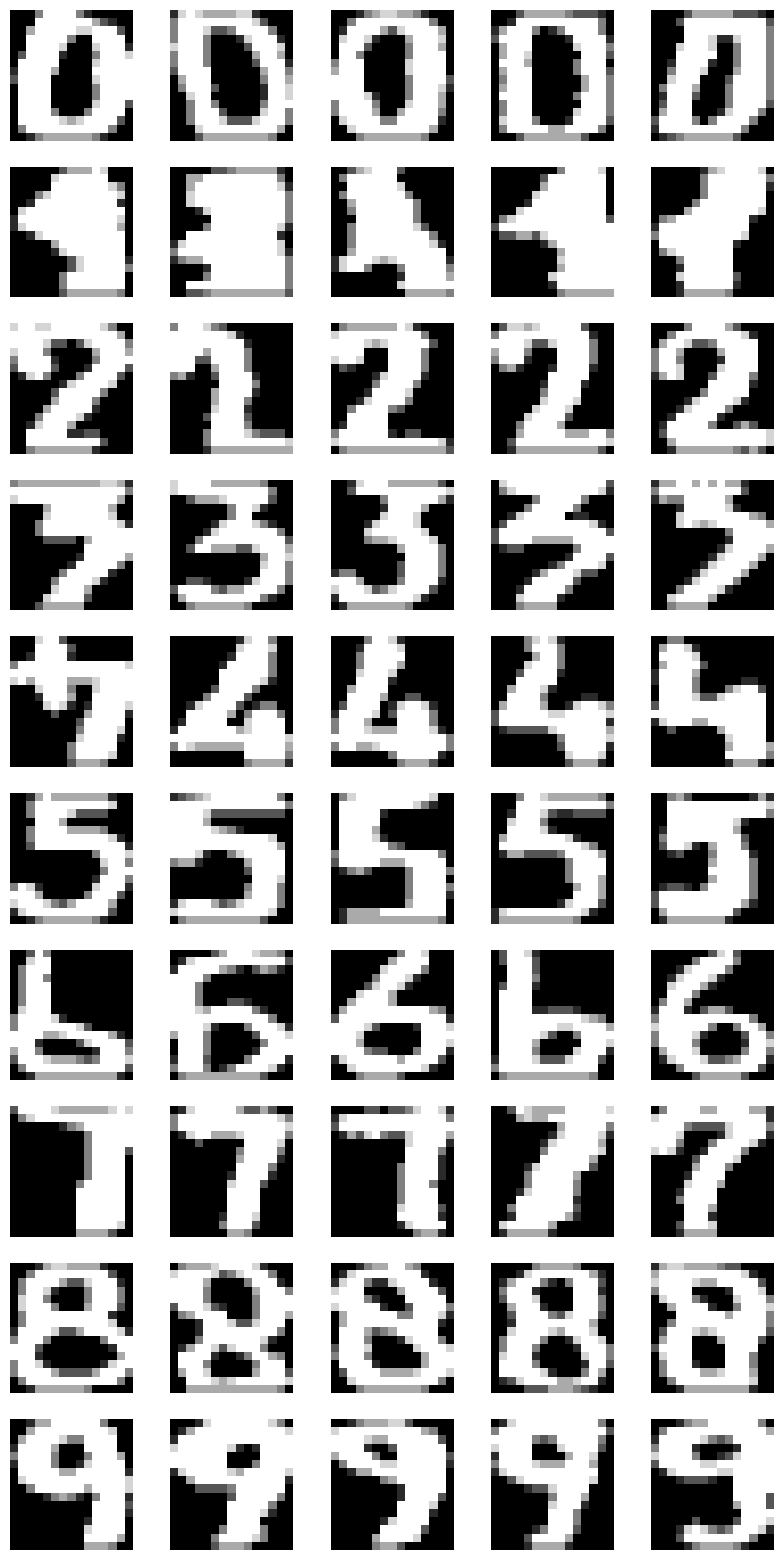

In [7]:
fig = plot_sample_for_each_digit(train_data, 5, (10, 20))
fig.savefig('figures/sample_images.svg', bbox_inches='tight')
plt.show()

# Linear regression (from the lecture notes)
given a collection of N training data points (xi, yi) where xi in R^n and yi in R
  - we have N = 1000
  - n = 240
  - range of xi is 0-6
  - range of yi is 0-9

Wanted: linear map from R^240 to R, represented by a _regression weight vector_ *w* (a row vector of size n = 240), which solves the minimization problem:
  - *w* = argmin_w sum_i (w \* xi - yi)^2
  - adding a bias to the argmin_w term, we get an affine linear function:
    - *w, b* = argmin_w,b sum_i (w \* xi + b - yi)^2
  - the bias can be added by adding a constant 1 to the end of each xi

Notes continue to explain that the n values of each component of the input vectors create n-dimensional vectors (p1,..., pn) a *?(not sure)* dimensional subspace *_F_* in R^N. The N target values of y also create a N-dimensional vector, our problem is finding a linear combination yopt = w1\*p1+...+wn\*pn that minimizes the distance to the target vector y given by the projection of y on *_F_*.

To solve we might need to understand a bit of linear algebra, but the application might do as well:
Define X = (p1...pn)', a matrix of size n x N which rows are p1,...,pn and columns are xi.
Also define y as a column vector of size N, with the target values yi.
Then we can find w_opt by w' = (XX')^-1 Xy

an optimization called _ridge regression_ is possible here by adding a small multiple of *I* (Identity) before doing the inverse:
 - w' = (XX' + small_value*I)^-1 Xy

#### Now lets try it

Perform linear ridge regression on the raw images
one-hot encode the labels

In [7]:
X = train_data

# one-hot encode the labels
y = ml_utils.one_hot_y(X)

w_opt = perform_linear_ridge_regression(X, y)

Test our classifier

In [8]:
evaluate_w_opt(w_opt, train_data, test_data, y, y)

train: misclassified: 23, misclassification rate: 2.3%
test: misclassified: 99, misclassification rate: 9.9%


(23, 99)

Compare to random

In [9]:
random_results = []
for _ in range(X.shape[0]):
    misclassified_random = 0
    choices = np.random.random(test_data.shape[0]) * 9
    for i in range(test_data.shape[0]):
        if round(choices[i]) != np.argmax(y[i]):
            misclassified_random += 1
    random_results.append(misclassified_random / test_data.shape[0])
random_results = np.array(random_results)

Random Misclassification Rate -- mean: 90.02%, min: 85.90%, max: 92.30%


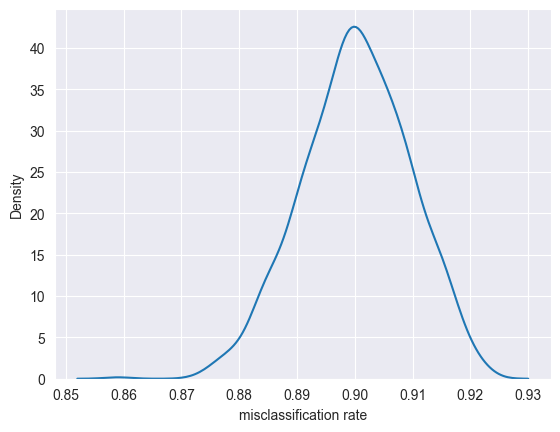

In [10]:
sns.kdeplot(random_results)
plt.xlabel("misclassification rate")
print(
    f"Random Misclassification Rate -- mean: {np.mean(random_results) * 100:.2f}%, min: {np.min(random_results) * 100:.2f}%, max: {np.max(random_results) * 100:.2f}%")

# Results ??

### using prototype vectors based on class means (from the lecture notes)

calculate class means and do a vector multiplication with each training image for each class

resulting in 10 features for each training image describing 'similarity' to the class mean

In [20]:
prototypes = []
n_images = n_image_in_category(train_data)
for i in range(10):
    start_index = i * n_images
    prototypes.append(np.mean(train_data[start_index:start_index + n_images], axis=0))
prototypes = np.array(prototypes)
prototypes.shape

(10, 240)

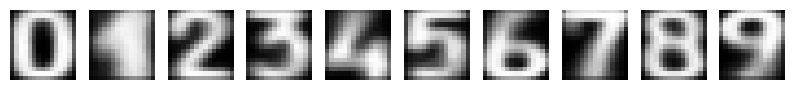

In [50]:
# plot all class means
fig = plot_sample_for_each_digit(prototypes, 1, (10, 1), horizontal=True)
fig.savefig('figures/prototypes.svg', bbox_inches='tight')

In [59]:
print(f'digit | sum | px>0.5 | avg')
for digit, prototype in enumerate(prototypes):
    # print(f'  {digit}   | {round(prototype.sum())} |   {(prototype > 0.5).sum()}  | {round(prototype.sum() / 240, 2)}')
    print(f'  {digit}   & {round(prototype.sum())} &   {(prototype > 0.5).sum()}  & {round(prototype.sum() / 240, 2):<04} \\\\')
print((prototypes.sum(axis=1) / 240).min())
print((prototypes.sum(axis=1) / 240).max())

digit | sum | px>0.5 | avg
  0   & 135 &   141  & 0.56 \\
  1   & 132 &   140  & 0.55 \\
  2   & 114 &   117  & 0.48 \\
  3   & 117 &   119  & 0.49 \\
  4   & 107 &   106  & 0.45 \\
  5   & 124 &   127  & 0.52 \\
  6   & 119 &   122  & 0.50 \\
  7   & 103 &   101  & 0.43 \\
  8   & 136 &   145  & 0.56 \\
  9   & 121 &   125  & 0.50 \\
0.430013888888889
0.5649027777777778


In [13]:
# multiply training images with class means
avg_feature_values_train = train_data @ prototypes.T
avg_feature_values_test = test_data @ prototypes.T
avg_feature_values_train.shape

(1000, 10)

now we have reduced X from 240 features to 10

try ridge regression again

In [14]:
w_opt = perform_linear_ridge_regression(avg_feature_values_train, y)

In [15]:
evaluate_w_opt(w_opt, avg_feature_values_train, avg_feature_values_test, y, y)

train: misclassified: 88, misclassification rate: 8.8%
test: misclassified: 91, misclassification rate: 9.1%


(88, 91)

Next we use K-fold cross validation to find the optimal number of principal components 

In [16]:
k_fold_misclassifications = []
n_folds = 50
for i in range(50):
    func = lambda train_set, val_set, train_y, val_y: ml_utils.pca_ridge_regression(
        train_set, val_set, train_y, val_y, n_components=i + 1)

    k_fold_results = ml_utils.k_fold_analysis(train_data, y, n_folds, func)

    k_fold_misclassifications.append(np.mean(k_fold_results, axis=0))
k_fold_misclassifications = np.array(k_fold_misclassifications)

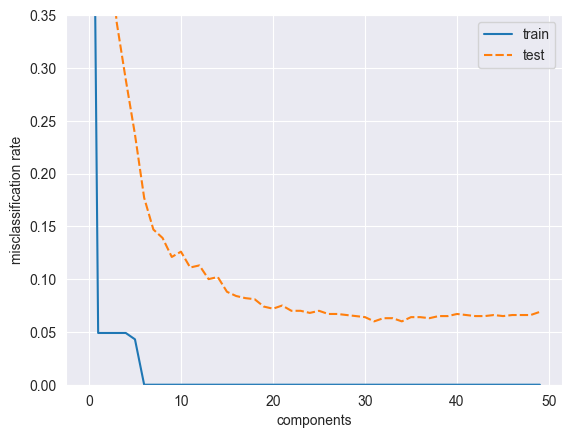

In [17]:
df = pd.DataFrame(k_fold_misclassifications, columns=['train', 'test'])
sns.lineplot(data=df)
plt.xlabel("components")
plt.ylabel("misclassification rate")
plt.ylim(0, 0.35)
plt.show()

In [18]:
print(
    f"best train result of PCA: {np.min(k_fold_misclassifications[:, 0]) * 100:.1f}% for {np.argmin(k_fold_misclassifications[:, 0])} components")
print(
    f"best val  result of PCA: {np.min(k_fold_misclassifications[:, 1]) * 100:.1f}% for {np.argmin(k_fold_misclassifications[:, 1])} components")
best_test_n_components = np.argmin(k_fold_misclassifications[:, 1])
print("there might be multiple minimum values:")
np.where(k_fold_misclassifications[:, 1] == k_fold_misclassifications[:, 1].min())

best train result of PCA: 0.0% for 6 components
best val  result of PCA: 6.0% for 31 components
there might be multiple minimum values:


(array([31]),)

### Use the results of the PCA to select n_components for training a final classifier and evaluate it on the Test set

In [19]:
pca = PCA(n_components=best_test_n_components, svd_solver='full')
fitted = pca.fit(train_data)
train_pca = fitted.transform(train_data)
test_pca = fitted.transform(test_data)

w_opt = perform_linear_ridge_regression(train_pca, y)
# arrays of correct and misclassified 'confidences'
confidences = [[], []]
# array of misclassified images
misclassified_images = []
# array of corresponding (real_y, predicted_y) tuples
misclassified_image_y = []
for i in range(y.shape[0]):
    img = test_pca[i]
    prediction = w_opt @ img
    predicted_y = np.argmax(prediction)
    confidence = prediction[predicted_y]
    real_y = np.argmax(y[i])
    if predicted_y == real_y:
        confidences[0].append(confidence)
    else:
        confidences[1].append(confidence)
        misclassified_images.append(img)
        misclassified_image_y.append((real_y, predicted_y))
misclassified_image_y = np.array(misclassified_image_y)
misclassified_images = pca.inverse_transform(misclassified_images)

In [20]:
evaluate_w_opt(w_opt, train_pca, test_pca, y, y)

train: misclassified: 51, misclassification rate: 5.1%
test: misclassified: 63, misclassification rate: 6.3%


(51, 63)

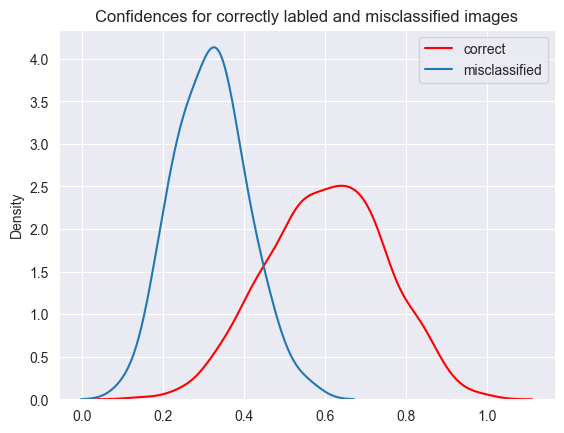

In [21]:
sns.kdeplot(confidences[0], color='r')
sns.kdeplot(confidences[1])
plt.legend(labels=['correct', 'misclassified'])
plt.title('Confidences for correctly labled and misclassified images')
plt.show()

plot all misclassified images after PCA reconstruction

note: is this ok? we get input from the test set here

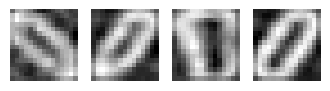

4        4        9        1


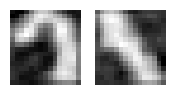

9        4


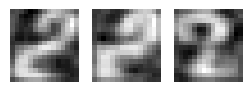

6        1        7


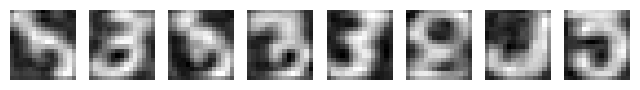

4        9        2        2        6        9        6        0


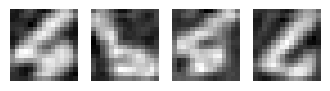

1        6        1        1


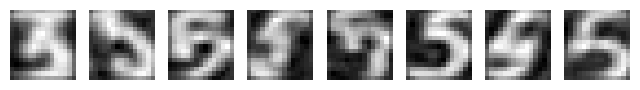

3        4        0        6        9        3        6        4


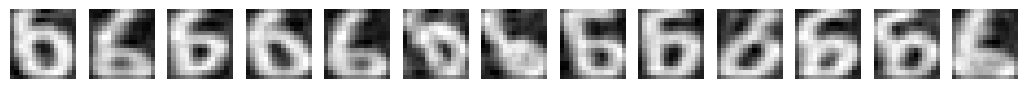

5        4        5        5        4        1        4        5        5        3        5        5        4


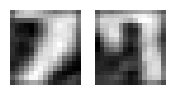

3        9


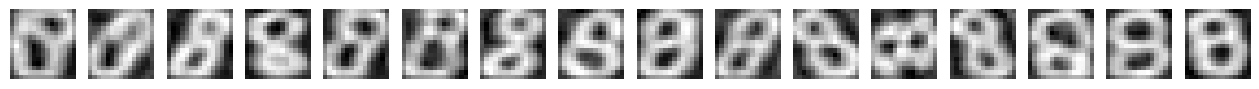

5        1        1        9        5        5        1        6        0        9        2        1        9        0        6        0


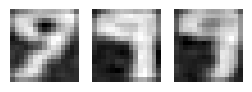

7        1        7


In [22]:
misclassified_per_class = [[] for _ in range(10)]
misclassified_per_class_y = [[] for _ in range(10)]
current_class = -1

for i in range(misclassified_image_y.shape[0]):
    real_y = misclassified_image_y[i, 0]
    if real_y != current_class:
        current_class = real_y
    misclassified_per_class[current_class].append(misclassified_images[i])
    misclassified_per_class_y[current_class].append(misclassified_image_y[i])

for k, images in enumerate(misclassified_per_class):
    img_in_class = len(images)
    if img_in_class > 0:
        figure = plt.figure(figsize=(img_in_class, 1))
        for i, img in enumerate(images):
            figure.add_subplot(1, img_in_class, i + 1)

            img = img.reshape(16, 15)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.show()
        predictions = [str(i[1]) for i in misclassified_per_class_y[k]]
        print('        '.join(predictions))


# circle madness

add one-hot-encoded circle features to the data
either before doing PCA (no performance increase)
or add the features to the principal components (go from 6% to 3.4% misclassifications) 

In [31]:
pca = PCA(n_components=best_test_n_components, svd_solver='full')

fitted = pca.fit(train_data)
train_pca = fitted.transform(train_data)
test_pca = fitted.transform(test_data)


    
# add circle features to principle components
train_pca = np.concatenate([train_pca, get_circle_data_as_feature(train_data)], axis=1)
test_pca = np.concatenate([test_pca, get_circle_data_as_feature(test_data)], axis=1)


w_opt = perform_linear_ridge_regression(train_pca, y)
# arrays of correct and misclassified 'confidences'
confidences = [[], []]
# array of misclassified images
misclassified_images = []
# array of corresponding (real_y, predicted_y) tuples
misclassified_image_y = []
for i in range(y.shape[0]):
    img = test_pca[i]
    prediction = w_opt @ img
    predicted_y = np.argmax(prediction)
    confidence = prediction[predicted_y]
    real_y = np.argmax(y[i])
    if predicted_y == real_y:
        confidences[0].append(confidence)
    else:
        confidences[1].append(confidence)
        # remove circle indicators from image
        misclassified_images.append(img[:-5])
        
        misclassified_image_y.append((real_y, predicted_y))
misclassified_image_y = np.array(misclassified_image_y)
misclassified_images = pca.inverse_transform(misclassified_images)
evaluate_w_opt(w_opt, train_pca, test_pca, y, y)

train: misclassified: 33, misclassification rate: 3.3%
test: misclassified: 34, misclassification rate: 3.4%


(33, 34)

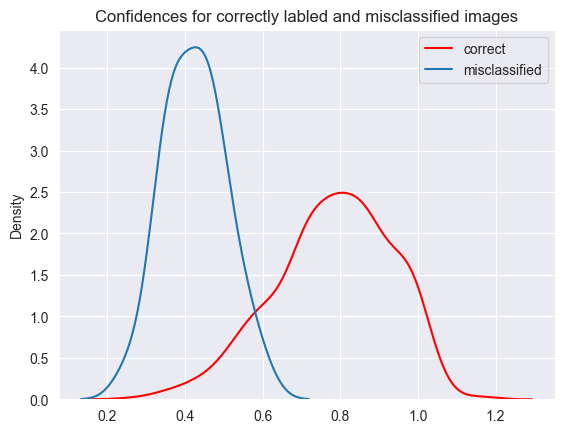

In [33]:
sns.kdeplot(confidences[0], color='r')
sns.kdeplot(confidences[1])
plt.legend(labels=['correct', 'misclassified'])
plt.title('Confidences for correctly labled and misclassified images')
plt.show()

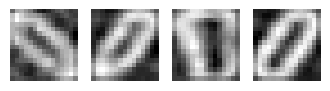

9        9        5        6


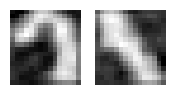

4        4


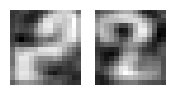

6        7


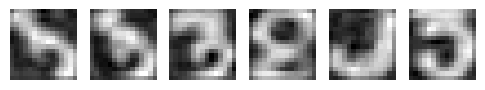

4        9        2        5        4        0


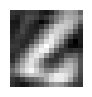

1


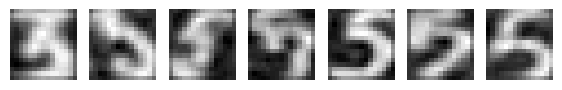

3        4        2        9        3        0        4


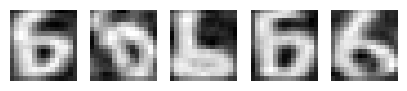

9        9        4        5        5


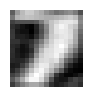

3


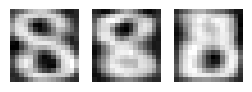

9        9        0


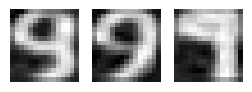

1        5        1


In [32]:
misclassified_per_class = [[] for _ in range(10)]
misclassified_per_class_y = [[] for _ in range(10)]
current_class = -1

for i in range(misclassified_image_y.shape[0]):
    real_y = misclassified_image_y[i, 0]
    if real_y != current_class:
        current_class = real_y
    misclassified_per_class[current_class].append(misclassified_images[i])
    misclassified_per_class_y[current_class].append(misclassified_image_y[i])

for k, images in enumerate(misclassified_per_class):
    img_in_class = len(images)
    if img_in_class > 0:
        figure = plt.figure(figsize=(img_in_class, 1))
        for i, img in enumerate(images):
            figure.add_subplot(1, img_in_class, i + 1)
            
            img = img.reshape(16, 15)

            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.show()
        predictions = [str(i[1]) for i in misclassified_per_class_y[k]]
        print('        '.join(predictions))